In [6]:
import numpy as np
import sys
# our functions
from tools import buildmodel as mtq
import mnist
# Clustering
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [18]:
save_dir="./mnist-dataset/"
(x_train , y_train) , (x_test, y_test) = mnist.load_mnist(save_dir)
y_train_origin = y_train
x_train , y_train = mnist.normalize_dataset(x_train, y_train)
y_test_origin = y_test
x_test, y_test = mnist.normalize_dataset(x_test, y_test)

print("size of the train dataset : ", len(x_train))

remote loading
size of the train dataset :  100


In [8]:
model = mtq.MTQModel(model_name)
load = True
model.build_dense((784,), n_neurons=[32,64, len(y_train[0])], load=load, summary=True)
if not load:
    model.fit(x_train,y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 27,362
Trainable params: 27,362
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
9/9 - 0s - loss: 0.2410 - accuracy: 0.5700
Epoch 2/15
9/9 - 0s - loss: 0.2109 - accuracy: 0.6100
Epoch 3/15
9/9 - 0s - loss: 0.1856 - accuracy: 0.6500
Epoch 4/15
9/9 - 0s - loss: 0.1647 - accuracy: 0.7400
Epoch 5/15
9/9 - 0s - loss: 0.1463 - accuracy: 0.8600
Epoch 6/15
9/9 - 0s - loss: 0.1309 - accuracy: 0.9300
Epoch 7/15
9/9 - 0s - loss: 0.1162 - accuracy: 0.9600
Epoc

In [24]:
hidden_layers = model.get_hidden_layers_outputs(x_train)
# normalize 
for i in range(len(hidden_layers)):
    hidden_layers[i] = hidden_layers[i] / np.amax(hidden_layers[i])

In [5]:
# Clustering with KMeans
cluster = KMeans(2).fit(first_hidden_output)
y_kmeans = cluster.predict(first_hidden_output)

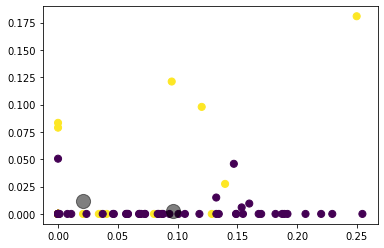

In [6]:
plt.scatter(first_hidden_output[:, 0], first_hidden_output[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = cluster.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

plt.show()

Loading BokehJS ...

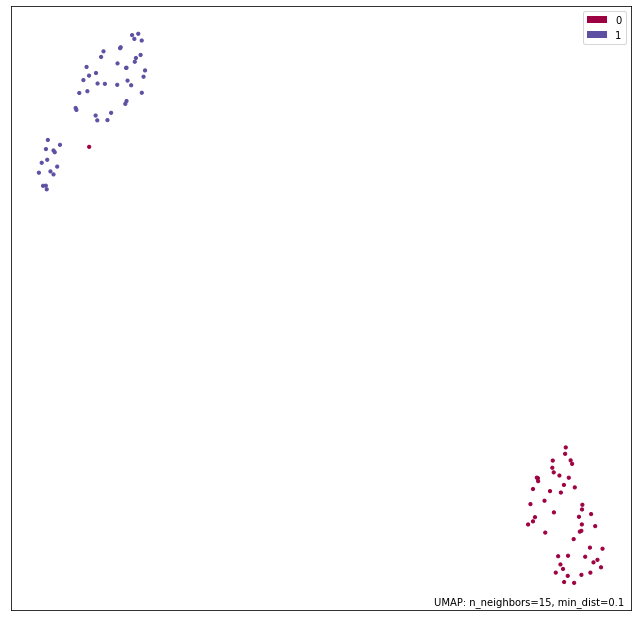

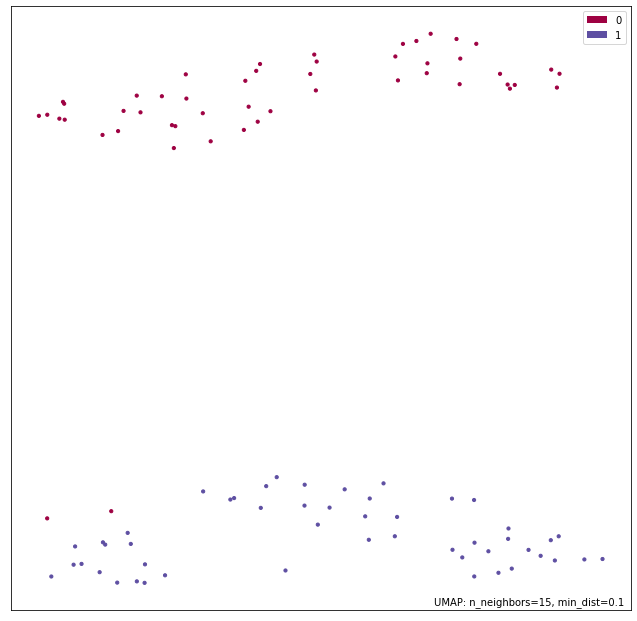

In [23]:
# UMAP

import umap.umap_
import umap.plot

umap.plot.output_notebook()
hover_data = pd.DataFrame({'index':np.arange(len(x_test)),
                           'label':y_test_origin})
for hd in hidden_layers:    
    mapper = umap.umap_.UMAP().fit(hd)
    #p = umap.plot.interactive(mapper, labels=y_test_origin, hover_data=hover_data)
    #umap.plot.show(p)

    umap.plot.points(mapper, labels=y_test_origin)